In [1]:
#Importing important Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Establish connection with database mysql
conn = pymysql.connect(
    host ='localhost',
    user ='root',
    password ='Mysql@2025',
    database ='loan_db'
)

In [3]:
#import data from database using sql
df_applicant = pd.read_sql("select * from applicantinfo",conn)
df_financial = pd.read_sql("select * from financialinfo",conn)
df_loan = pd.read_sql("select * from loaninfo",conn)

In [4]:
# getting idea about appllication
df_applicant.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed
0,LP001002,Male,No,0,Graduate,No
1,LP001003,Male,Yes,1,Graduate,No
2,LP001005,Male,Yes,0,Graduate,Yes
3,LP001006,Male,Yes,0,Not Graduate,No
4,LP001008,Male,No,0,Graduate,No


In [5]:
 #getting idea about finance
df_financial.head()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,LP001002,5849,0.0,NaN,360.0,1.0
1,LP001003,4583,1508.0,128.0,360.0,1.0
2,LP001005,3000,0.0,66.0,360.0,1.0
3,LP001006,2583,2358.0,120.0,360.0,1.0
4,LP001008,6000,0.0,141.0,360.0,1.0


In [6]:
 #getting idea about Loan
df_loan.head()

,Loan_ID,Property_Area,Loan_Status
0,LP001002,Urban,Y
1,LP001003,Rural,N
2,LP001005,Urban,Y
3,LP001006,Urban,Y
4,LP001008,Urban,Y


In [7]:
#Close the sql connection
conn.close()

In [8]:
# Merge into a single dataframe
df = df_applicant.merge (df_financial, on ='Loan_ID').merge(df_loan, on ='Loan_ID')
df = df.drop('Loan_ID', axis = 1)


In [9]:
#Check the first 5 records
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [10]:
# Quick check of the data retrieved
print('Shape:',df.shape)
print('Row:', df.shape[0])
print('cilumns:',df.shape[1])

Shape: (614, 12)
Row: 614
cilumns: 12


In [11]:
#Quick EDA / sanity checks
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [12]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Gender,601,2,Male,489,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Married,611,2,Yes,398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,599,4,0,345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education,614,2,Graduate,480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Self_Employed,582,2,No,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ApplicantIncome,614.0,NaN,NaN,NaN,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.0,81000.0
CoapplicantIncome,614.0,NaN,NaN,NaN,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,NaN,NaN,NaN,146.412162,85.587325,9.0,100.0,128.0,168.0,700.0
Loan_Amount_Term,600.0,NaN,NaN,NaN,342.0,65.12041,12.0,360.0,360.0,360.0,480.0
Credit_History,564.0,NaN,NaN,NaN,0.842199,0.364878,0.0,1.0,1.0,1.0,1.0


In [13]:
df.isnull().sum().sort_values(ascending=False)

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Education             0
CoapplicantIncome     0
ApplicantIncome       0
Property_Area         0
Loan_Status           0
dtype: int64

In [14]:
df.duplicated().sum()

np.int64(0)

In [15]:
# target distribution
print(df['Loan_Status'].value_counts(normalize=True))

Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64


In [16]:
# Create simple features
df['Dependents'] = df['Dependents'].replace('3+', '3')
df['Dependents'] = df['Dependents'].astype(float)


In [17]:
# numeric features (add engineered ones)
numeric_features = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History']
# categorical features
categorical_features = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area']


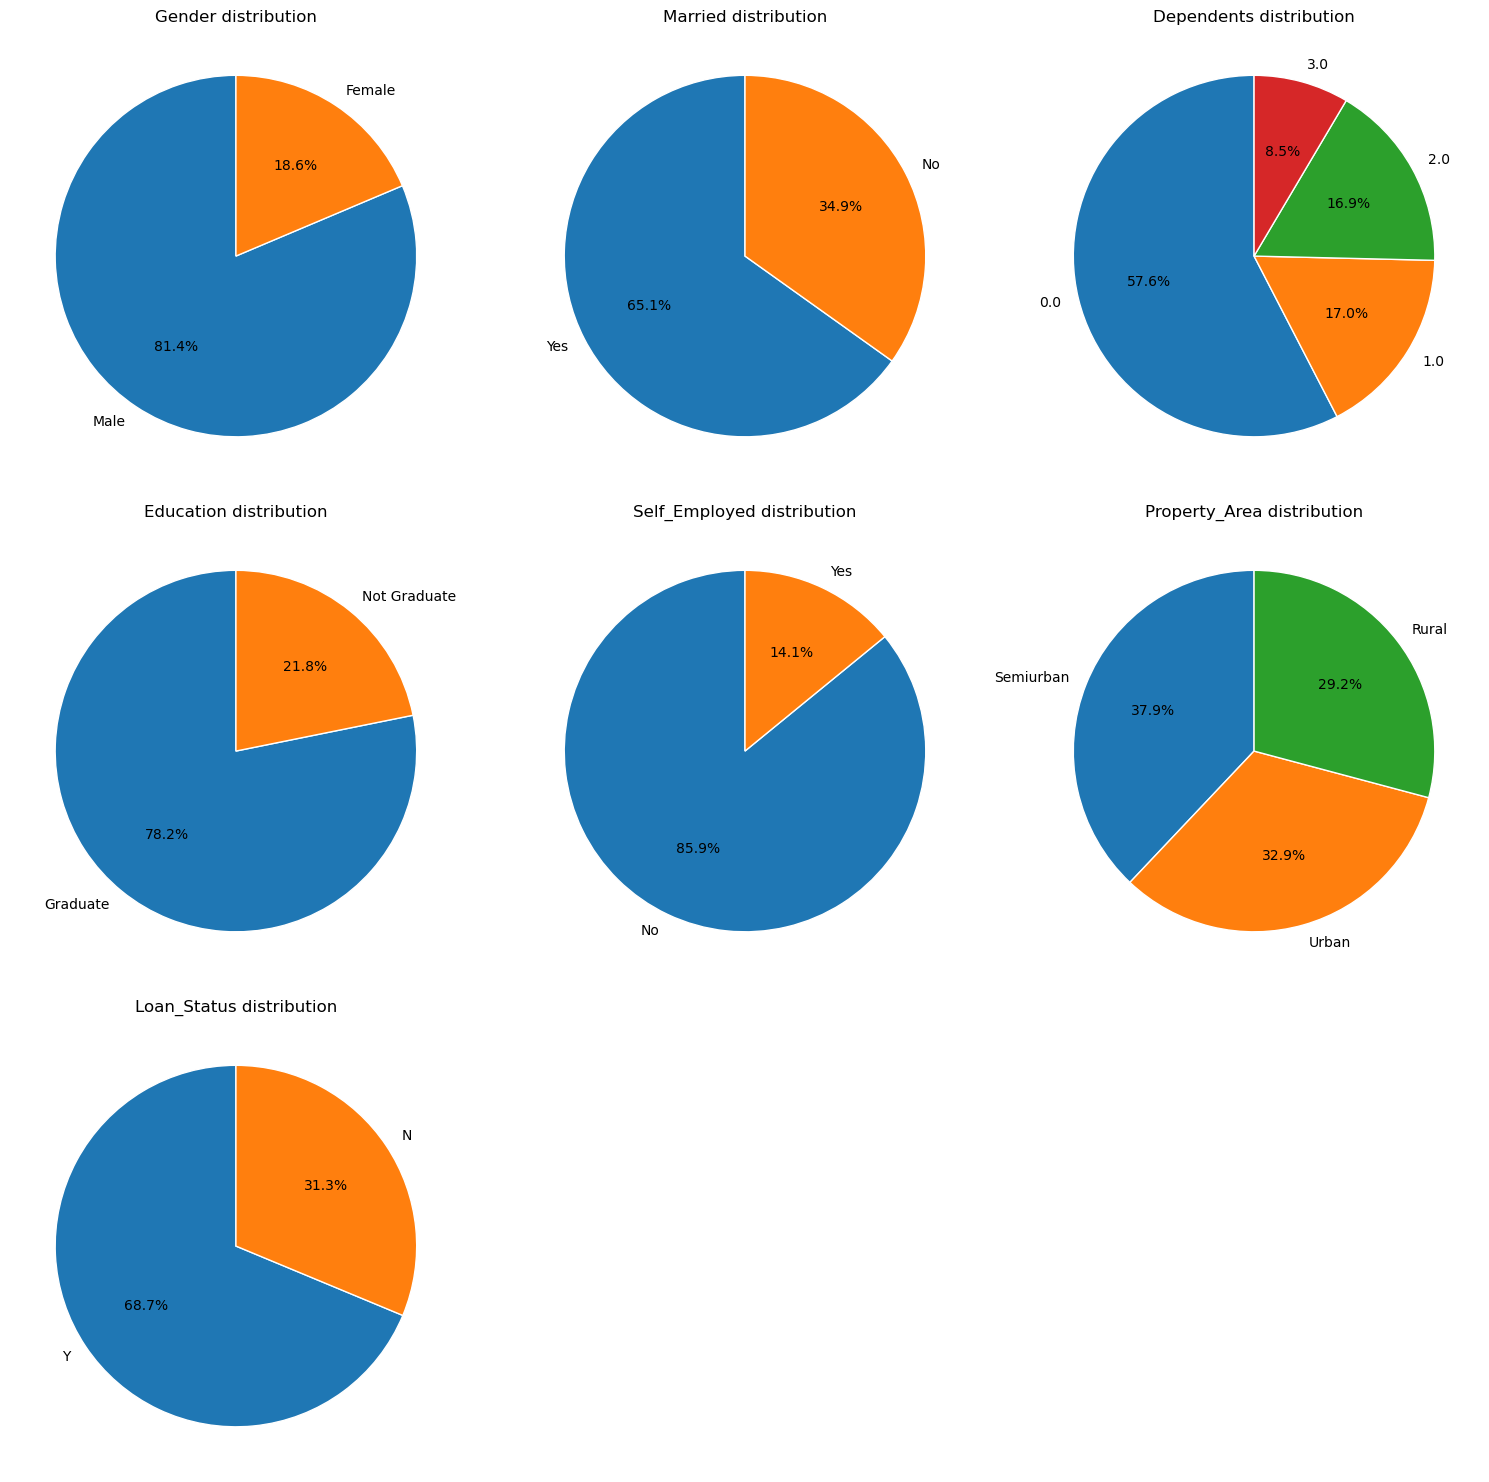

In [18]:
# list of categorical columns in loan dataset
categorical_features = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']

# number of subplots
n = len(categorical_features)
ncols = 3   # adjust layout (3 per row is usually neat)
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5*nrows))

for i, col in enumerate(categorical_features):
    ax = axes[i // ncols, i % ncols]
    df[col].value_counts().plot.pie(
        autopct='%1.1f%%', ax=ax, startangle=90, 
        wedgeprops={'linewidth':1, 'edgecolor':'white'}
    )
    ax.set_ylabel('')
    ax.set_title(f'{col} distribution')

# hide empty subplot slots if any
for j in range(i+1, nrows*ncols):
    fig.delaxes(axes[j//ncols, j%ncols])

plt.tight_layout()
plt.show()


In [19]:
#Target encoding
df['Loan_Status'] = df['Loan_Status'].map({'Y':1, 'N':0})
target = 'Loan_Status'

In [20]:

#Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
    #,('scaler', StandardScaler())   # scaler useful for logistic regression
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [21]:
# Train/test split
X = df[numeric_features + categorical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [22]:
#Model training, evaluation, saving (baseline LR + Random Forest)
# Logistic Regression pipeline
pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=100, class_weight='balanced'))  # set class_weight if imbalance
])

# Random Forest pipeline (no scaling strictly needed, but we reuse preprocessor)
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, class_weight='balanced'))
])


In [23]:
# Model fit
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Logistic Regression
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        85

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123



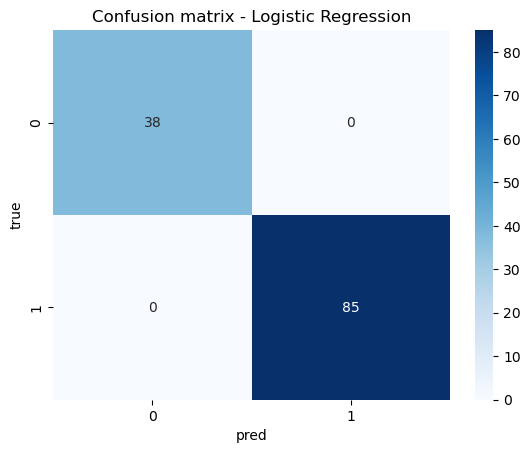

Random Forest
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        85

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123



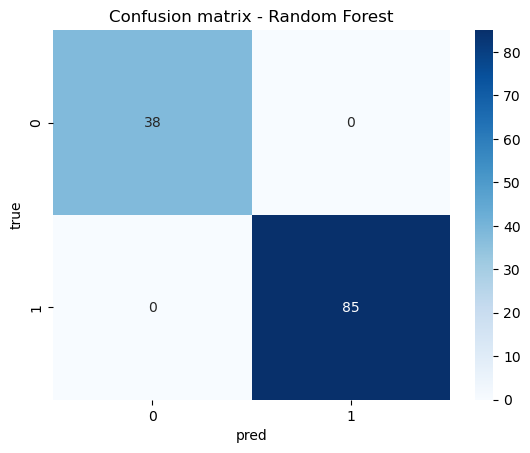

In [24]:
#Evaluate on test set (metrics + confusion matrix)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate(model, X_test, y_test, name='model'):
    preds = model.predict(X_test)
    print(name)
    print('Accuracy:', accuracy_score(y_test, preds))
    print('Precision:', precision_score(y_test, preds))
    print('Recall:', recall_score(y_test, preds))
    print('F1:', f1_score(y_test, preds))
    print('\nClassification report:\n', classification_report(y_test, preds))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('pred')
    plt.ylabel('true')
    plt.title(f'Confusion matrix - {name}')
    plt.show()

evaluate(pipe_lr, X_test, y_test, 'Logistic Regression')
evaluate(pipe_rf, X_test, y_test, 'Random Forest')


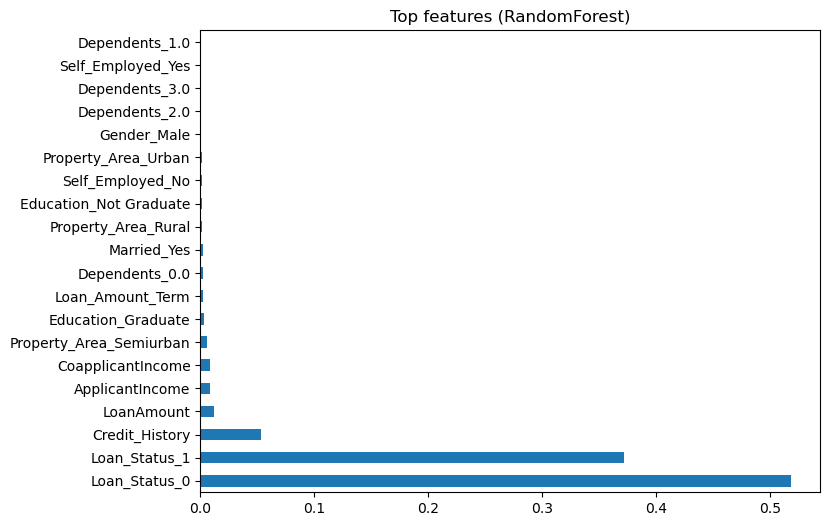

In [25]:
# Feature importances / interpretation
# fit the preprocessor on the training data to get feature names
preprocessor.fit(X_train)

# numeric names
num_names = numeric_features

# categorical: get feature names from OneHotEncoder
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(categorical_features)

feature_names = np.concatenate([num_names, cat_names])

# get importances from RF model
rf_clf = pipe_rf.named_steps['clf']
importances = rf_clf.feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
fi.head(20).plot.barh(figsize=(8,6))
plt.title('Top features (RandomForest)')
plt.show()


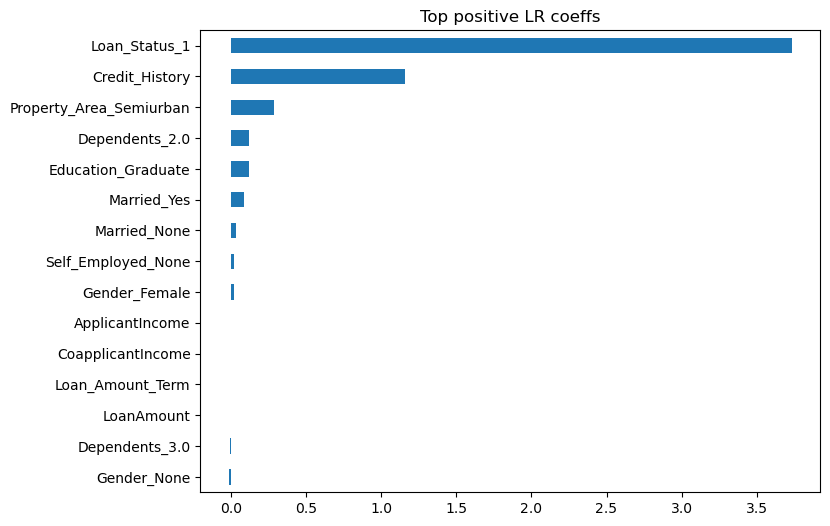

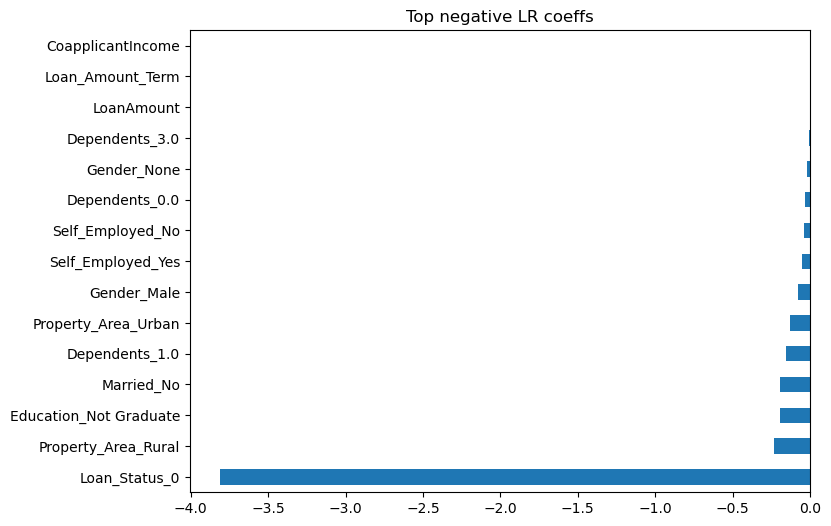

In [26]:
# Logistic Regression coefficients (after scaling/one-hot)
lr_clf = pipe_lr.named_steps['clf']
coefs = lr_clf.coef_.ravel()
coef_ser = pd.Series(coefs, index=feature_names).sort_values()
coef_ser.tail(15).plot.barh(figsize=(8,6)); plt.title('Top positive LR coeffs'); plt.show()
coef_ser.head(15).plot.barh(figsize=(8,6)); plt.title('Top negative LR coeffs'); plt.show()


In [27]:
#Cross-validation and simple hyperparameter tuning (optional but recommended)
from sklearn.model_selection import cross_val_score , GridSearchCV

# quick CV
cv_scores = cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring='f1')
print('RF CV F1 (5-fold):', cv_scores.mean(), cv_scores.std())

# small GridSearch (example)
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 8, 12]
}
gs = GridSearchCV(pipe_rf, param_grid, cv=3, scoring='f1', n_jobs=-1)
gs.fit(X_train, y_train)
print('Best params:', gs.best_params_)
best_rf = gs.best_estimator_


RF CV F1 (5-fold): 1.0 0.0
Best params: {'clf__max_depth': None, 'clf__n_estimators': 100}


In [28]:
# choose the best model (e.g., best_rf or pipe_rf)
import pickle
final_model = pipe_rf  # or gs.best_estimator_ if you did GridSearch
with open('besy_model.pkl','wb') as f:
    pickle.dump(final_model, f)
